In [1]:
import sys
import requests
import zipfile
import urllib3
import matplotlib
import numpy as np

from pathlib import Path
from os import getcwd, makedirs, rename
from os.path import join, basename, isdir

sys.path.append(str(Path(getcwd()).parent))
current_dir = getcwd()
print(current_dir)

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

urllib3.disable_warnings()

/home/jvas22/Documentos/joao/AnaliseEnsinoSuperiorPublico/notebooks


In [2]:
class Dados:
    def __init__(self):
        dicionarioDados = pd.read_csv(join(Path(getcwd()).parent,'dicionario_dados.csv'), sep = ";")
        self.schema = dicionarioDados

        self.parser = dict([[column, eval(parser.replace("“","\"").replace("”","\""))] for column, parser in dicionarioDados.loc[(dicionarioDados['TRADUCAO'].notna()),['COLUNA','TRADUCAO']].values])
        self.fillna = dict(dicionarioDados.loc[dicionarioDados['NULO'].notna(),['COLUNA','NULO']].values)
        self.dtypes = dict(dicionarioDados[['COLUNA','TIPOS']].values)
        self.meaning = dict(dicionarioDados[['COLUNA', 'DESCRICAO']])

    #METODO PARA TRADUZIR OS IDS SEGUNDO O DICIONARIO DE DADOS
    def traduzDados(self):
        print("Iniciando merge das variaveis com o dicionário de dados")
        for col in self.schema.loc[self.schema['NULO'].notna(),'COLUNA'].values:
            self.DataFrame[col] = self.DataFrame[col].fillna(self.fillna[col]).astype(self.dtypes[col])

        for col in self.schema.loc[self.schema['TRADUCAO'].notna(),'COLUNA'].values:
            self.DataFrame.replace(self.parser,inplace=True)

    #METODO PARA BAIXAR BASE DE DADOS CASO NÃO ENCONTRAR A PASTA "DADOS"
    def baixaDados(self, url, endereco=None):
        if not isdir(join(Path(getcwd()).parent,"dados")):
            makedirs(join(Path(getcwd()).parent,"dados"))
            if endereco is None:
                endereco = join(Path(getcwd()).parent,"dados", basename(url.split("/")[4]))
            resposta = requests.get(url, stream=True, verify=False)
            if resposta.status_code == requests.codes.OK:
                with open(endereco, 'wb') as novo_arquivo:
                        for parte in resposta.iter_content(chunk_size=256):
                            novo_arquivo.write(parte)
                print("Download finalizado. Arquivo salvo em: {}".format(endereco))
                if not isdir(join(Path(getcwd()).parent,"dados",str(basename(url.split("/")[4])).replace(".zip",""))):
                    with zipfile.ZipFile(join(Path(getcwd()).parent,"dados", basename(url.split("/")[4])), 'r') as zip_ref:
                        zip_ref.extractall(join(Path(getcwd()).parent,"dados"))
                    rename(join(Path(getcwd()).parent,"dados","Microdados do Censo da Educaç╞o Superior 2020"),join(Path(getcwd()).parent,"dados",str(basename(url.split("/")[4])).replace(".zip","")))
            else:
                resposta.raise_for_status()

    def importaDados(self, entrada="MICRODADOS_CADASTRO_CURSOS_2020.CSV"):
        print("Iniciando leitura do arquivo {}".format(entrada))
        self.baixaDados("https://download.inep.gov.br/microdados/microdados_censo_da_educacao_superior_2020.zip")
        caminho_entrada = join(Path(getcwd()).parent,"dados","microdados_censo_da_educacao_superior_2020", "dados")
        self.DataFrame = pd.read_csv(join(caminho_entrada,str(entrada).split(",")[0]), sep = ';', low_memory = False, encoding = 'latin-1').reset_index()
        count = 0
        for arquivo in str(entrada).replace(" ","").split(","):
            if count == 0:
                count = count+1
            else:
                self.DataFrame.merge(pd.read_csv(join(caminho_entrada,arquivo), sep = ';', low_memory = False, encoding = 'latin-1').reset_index(), how = 'left', on = 'index')
        self.DataFrame = self.DataFrame.set_index('index')

class Individuo:
    def __init__(self, nome):
        self.nome = nome
        self.cor = None
        self.sexo = None
        self.faixa_etaria = None

    def alteraNomeColunas(self):
        if self.nome == 'ingressantes':
            self.cor.rename(columns={'QT_ING_AMARELA': 'AMARELA', 'QT_ING_INDIGENA':'INDIGENA', 'QT_ING_PARDA': 'PARDA', 'QT_ING_PRETA': 'PRETA', 'QT_ING_BRANCA': 'BRANCA', 'QT_ING_CORND': 'NÃO DECLARADA'}, inplace=True)
            self.sexo.rename(columns={'QT_ING_MASC':'MASCULINO','QT_ING_FEM':'FEMININO'}, inplace=True)
        if self.nome == 'concluintes':
            self.cor.rename(columns={'QT_CONC_AMARELA': 'AMARELA', 'QT_CONC_INDIGENA':'INDIGENA', 'QT_CONC_PARDA': 'PARDA', 'QT_CONC_PRETA': 'PRETA', 'QT_CONC_BRANCA': 'BRANCA', 'QT_CONC_CORND': 'NÃO DECLARADA'}, inplace=True)
            self.sexo.rename(columns={'QT_CONC_MASCULINO':'MASC','QT_CONC_FEM':'FEMININO'}, inplace=True)

In [3]:
dados = Dados()
dados.importaDados("MICRODADOS_CADASTRO_CURSOS_2020.CSV")
dados.traduzDados()
#dados.DataFrame

Iniciando leitura do arquivo MICRODADOS_CADASTRO_CURSOS_2020.CSV
Iniciando merge das variaveis com o dicionário de dados


In [4]:
UniversidadePublica = dados.DataFrame.loc[(dados.DataFrame.TP_ORGANIZACAO_ACADEMICA == 'Universidade') & (dados.DataFrame.TP_REDE == 'Pública')]
print('Cursos de universidades públicas: {}/{}'.format(UniversidadePublica.shape[0], dados.DataFrame.shape[0]))

Cursos de universidades públicas: 13220/335629


In [5]:
ingressantes = Individuo('ingressantes')
ingressantes.cor = UniversidadePublica.groupby(['NO_REGIAO', 'NO_UF'])[dados.schema.loc[(dados.schema.INDIVIDUO == 'ingressantes') & (dados.schema.INDICADORES == 'cor'), 'COLUNA']].sum()
ingressantes.sexo= UniversidadePublica.groupby(['NO_REGIAO', 'NO_UF'])[dados.schema.loc[(dados.schema.INDIVIDUO == 'ingressantes') & (dados.schema.INDICADORES == 'sexo'), 'COLUNA']].sum()
ingressantes.faixa_etaria = UniversidadePublica.groupby(['NO_REGIAO', 'NO_UF'])[dados.schema.loc[(dados.schema.INDIVIDUO == 'ingressantes') & (dados.schema.INDICADORES == 'faixa_etaria'), 'COLUNA']].sum()
ingressantes.alteraNomeColunas()

concluintes = Individuo('concluintes')
concluintes.cor = UniversidadePublica.groupby(['NO_REGIAO', 'NO_UF'])[dados.schema.loc[(dados.schema.INDIVIDUO == 'concluintes') & (dados.schema.INDICADORES == 'cor'), 'COLUNA']].sum()
concluintes.sexo= UniversidadePublica.groupby(['NO_REGIAO', 'NO_UF'])[dados.schema.loc[(dados.schema.INDIVIDUO == 'concluintes') & (dados.schema.INDICADORES == 'sexo'), 'COLUNA']].sum()
concluintes.faixa_etaria = UniversidadePublica.groupby(['NO_REGIAO', 'NO_UF'])[dados.schema.loc[(dados.schema.INDIVIDUO == 'concluintes') & (dados.schema.INDICADORES == 'faixa_etaria'), 'COLUNA']].sum()
concluintes.alteraNomeColunas()

array([<AxesSubplot: title={'center': 'Centro-Oeste'}>,
       <AxesSubplot: title={'center': 'Nordeste'}>,
       <AxesSubplot: title={'center': 'Norte'}>,
       <AxesSubplot: title={'center': 'Sudeste'}>,
       <AxesSubplot: title={'center': 'Sul'}>], dtype=object)

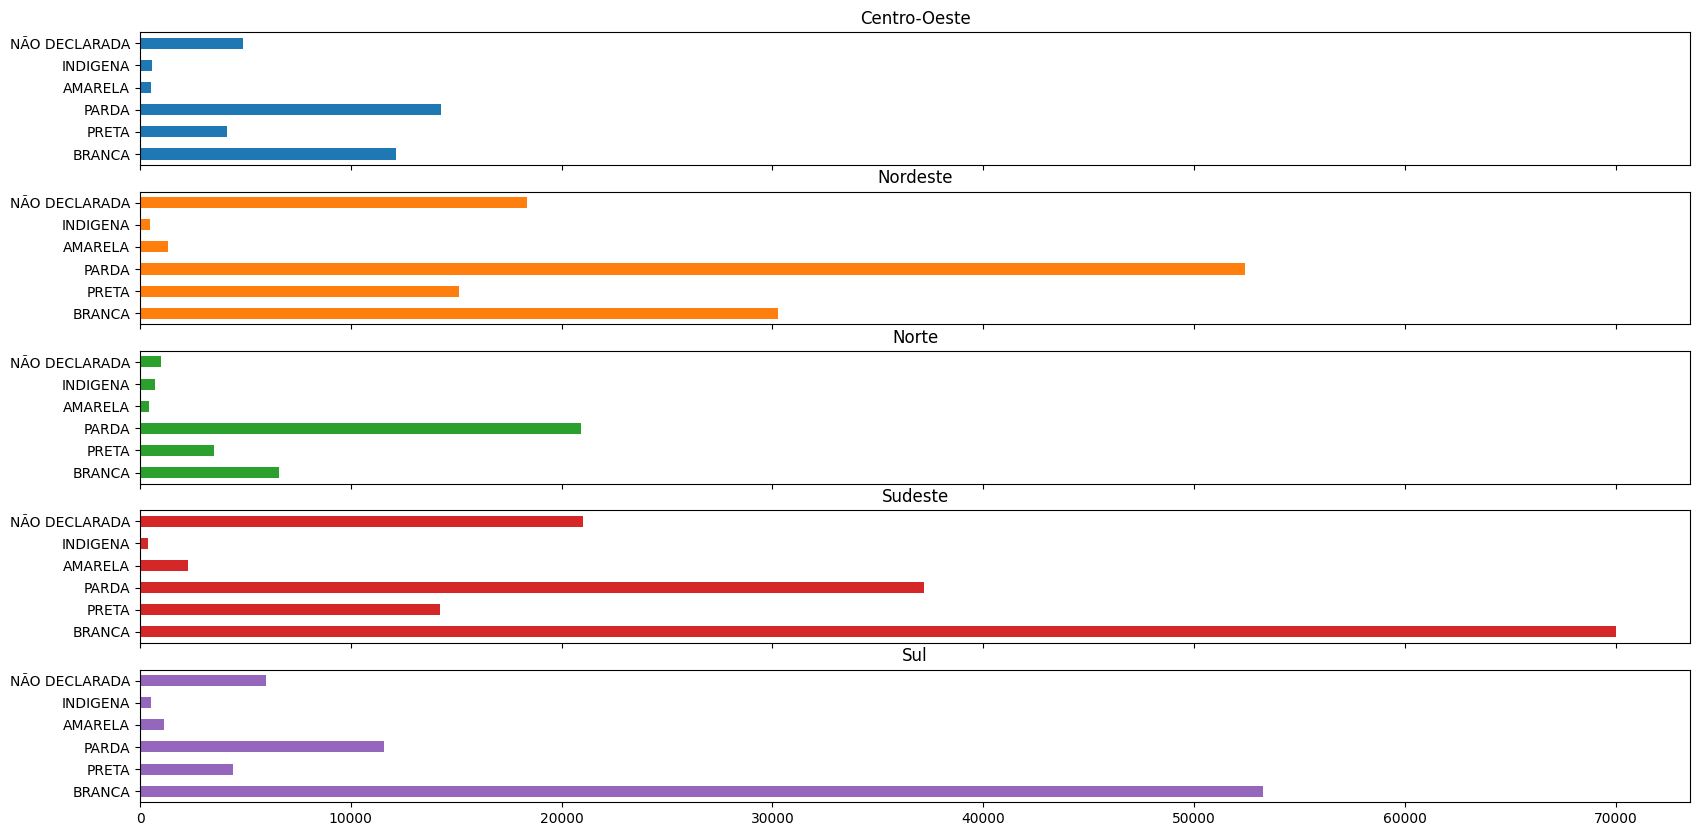

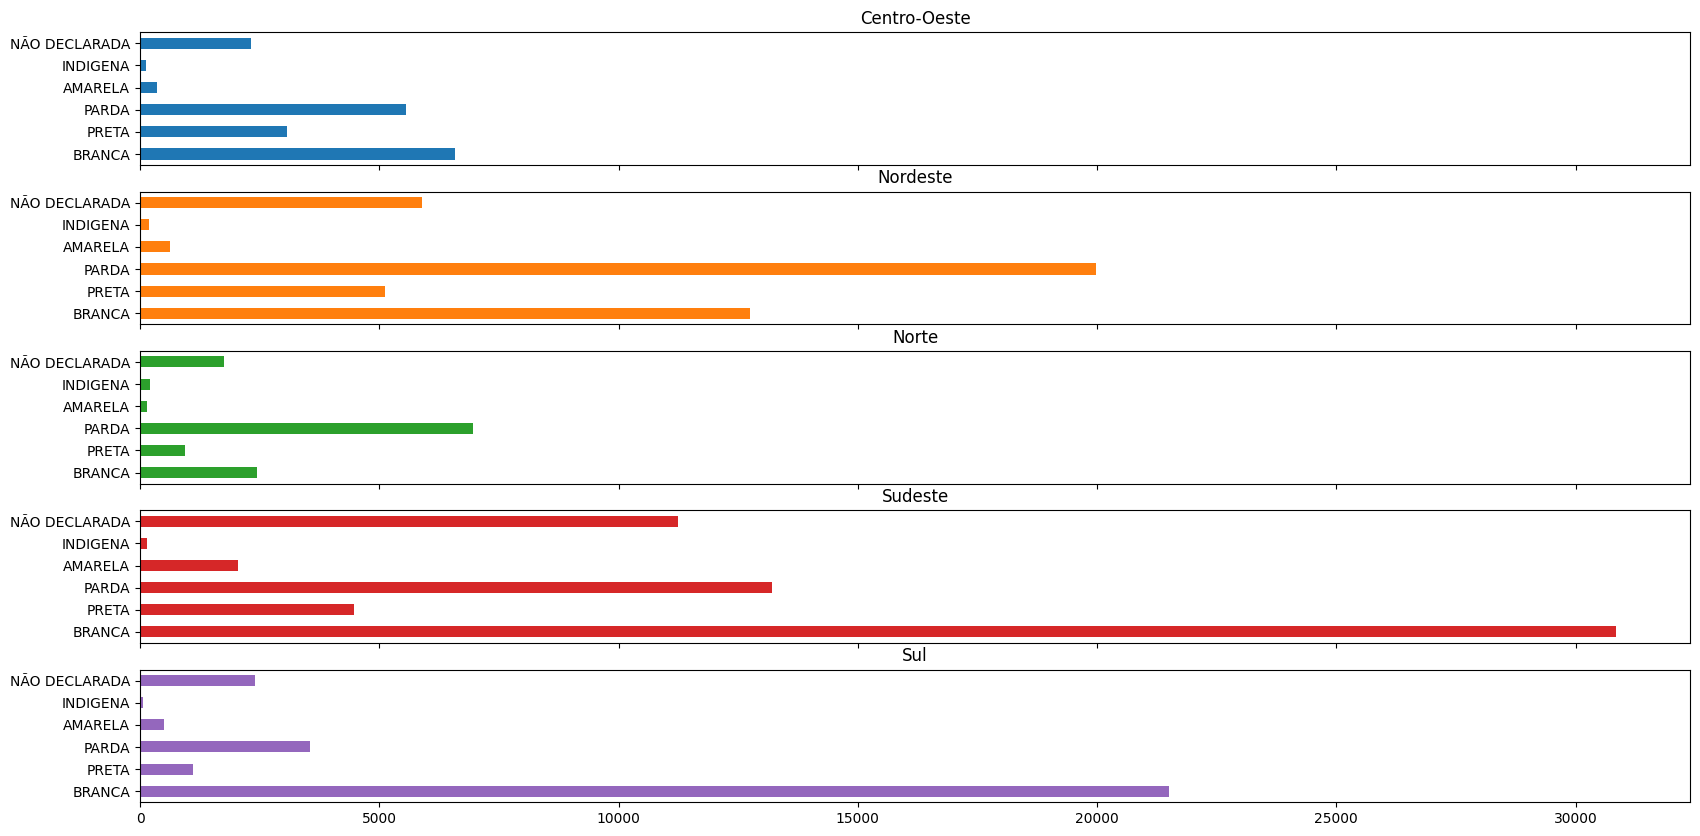

In [6]:
ingressantes.cor.droplevel(1).groupby('NO_REGIAO').sum().T.plot(kind='barh', subplots=True, legend=False, figsize=(20,10))
concluintes.cor.droplevel(1).groupby('NO_REGIAO').sum().T.plot(kind='barh', subplots=True, legend=False, figsize=(20,10))

array([<AxesSubplot: ylabel='Centro-Oeste'>,
       <AxesSubplot: ylabel='Nordeste'>, <AxesSubplot: ylabel='Norte'>,
       <AxesSubplot: ylabel='Sudeste'>, <AxesSubplot: ylabel='Sul'>],
      dtype=object)

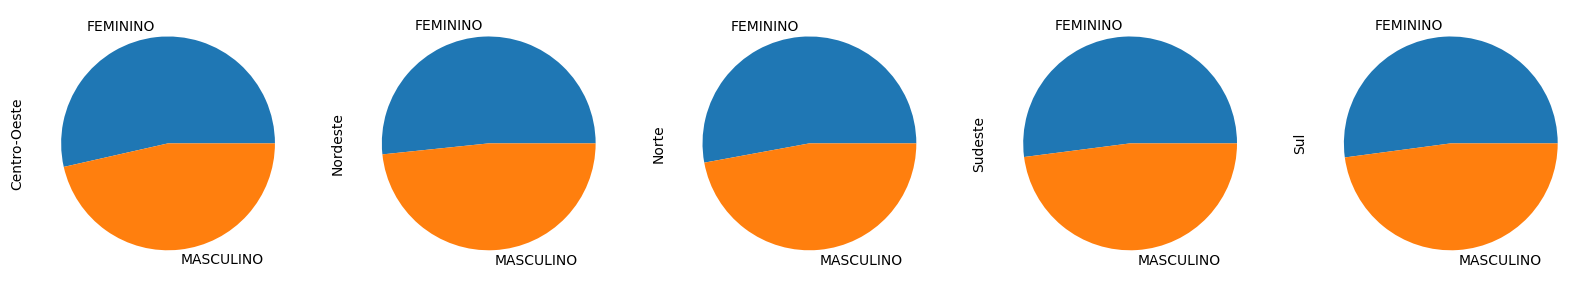

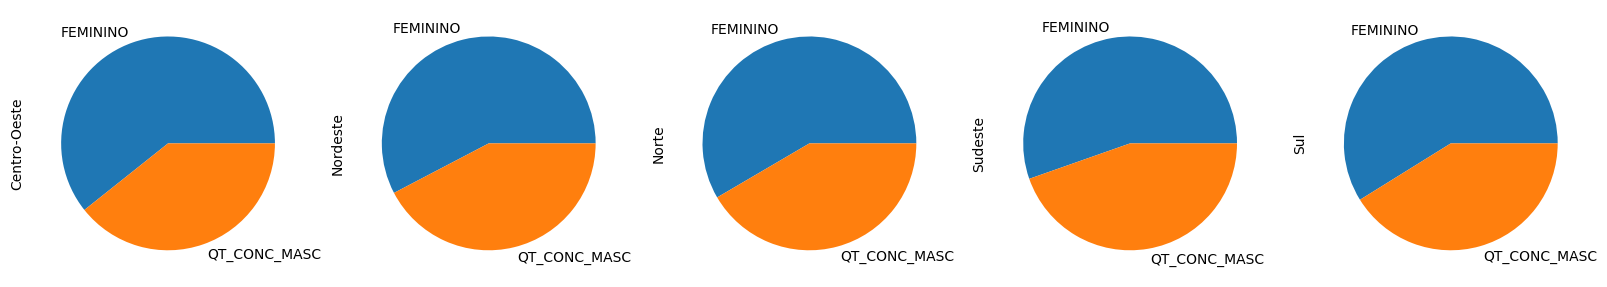

In [7]:
ingressantes.sexo.droplevel(1).groupby('NO_REGIAO').sum().T.plot(kind='pie', subplots=True, legend=False, figsize=(20,10))
concluintes.sexo.droplevel(1).groupby('NO_REGIAO').sum().T.plot(kind='pie', subplots=True, legend=False, figsize=(20,10))

array([<AxesSubplot: title={'center': 'Centro-Oeste'}>,
       <AxesSubplot: title={'center': 'Nordeste'}>,
       <AxesSubplot: title={'center': 'Norte'}>,
       <AxesSubplot: title={'center': 'Sudeste'}>,
       <AxesSubplot: title={'center': 'Sul'}>], dtype=object)

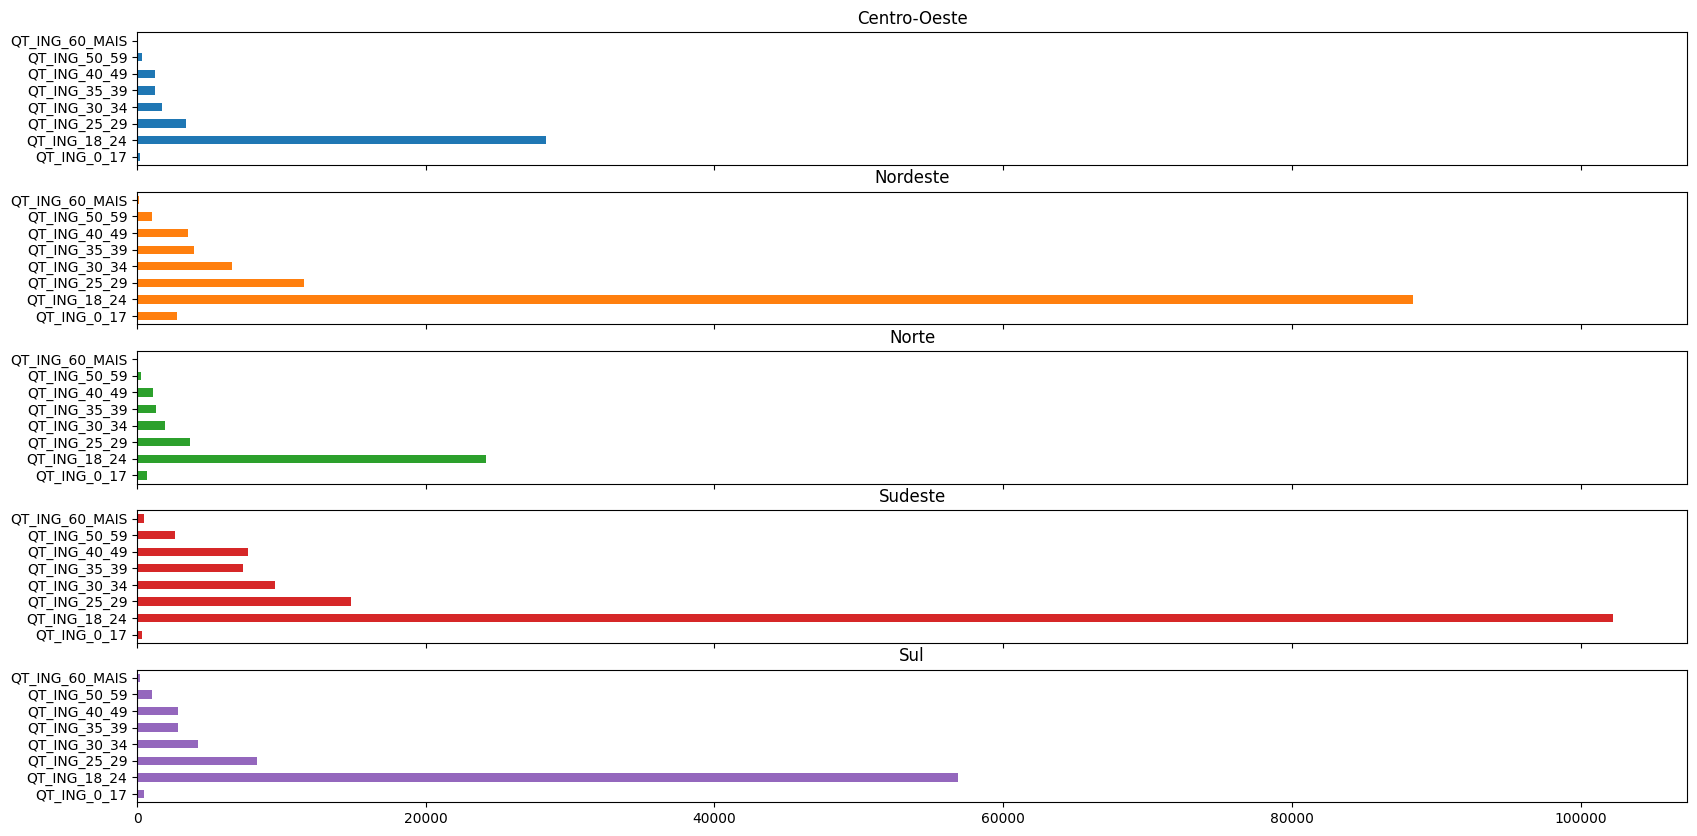

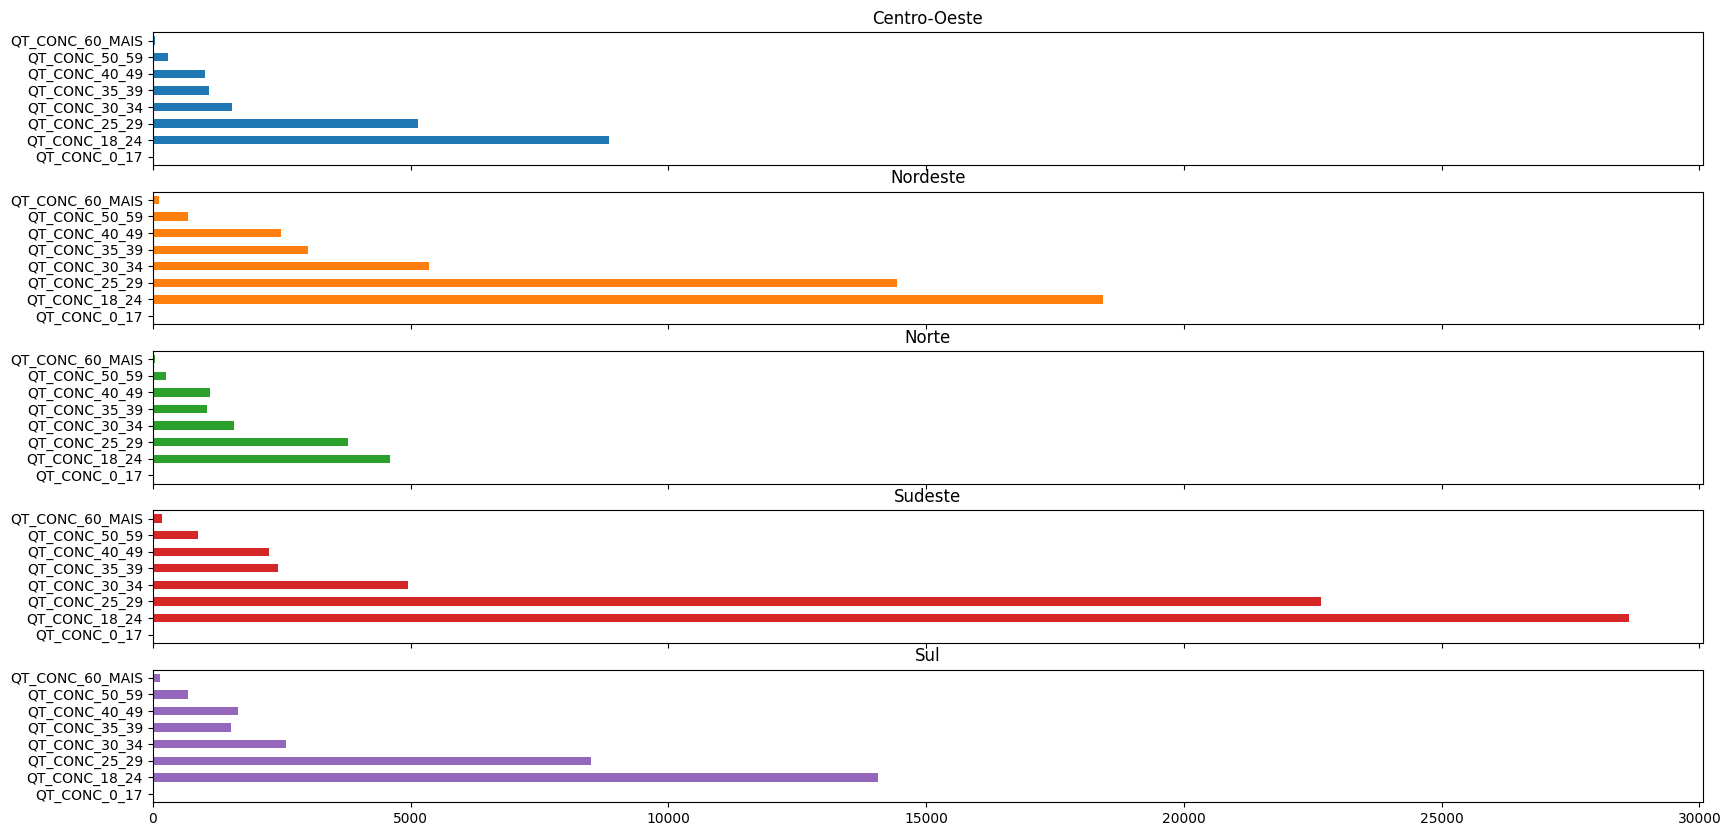

In [8]:
ingressantes.faixa_etaria.droplevel(1).groupby('NO_REGIAO').sum().T.plot(kind='barh', subplots=True, legend=False, figsize=(20,10))
concluintes.faixa_etaria.droplevel(1).groupby('NO_REGIAO').sum().T.plot(kind='barh', subplots=True, legend=False, figsize=(20,10))